
## Harmonic oscillator (min T) including a control loss region (initial problem)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min  T, \\[0.5em]
        \dot{x}_1(t) = x_2(t), \; t\in [0,T]\\[0.5em]
        \dot{x}_2(t) = u(t)-x_1(t), t\in [0,T]  \\[0.5em]
        u(t) \in [-1, 1], \; t\in [0,T]\\[0.5em]
        x(0) = (4.2,0) , \quad x(T) = 0_{\mathrm{R}^2}, \\[0.5em]
        \{x \mid x_2 < 0\} \text{ is a control loss reigon.}
    \end{array}
    \right.
$$

## Harmonic oscillator (min T) including a control loss region (regularized problem)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min  T + \varepsilon \int_0^T v^2(t)dt + \int_0^T f_{NC}(x_2(t))u^2(t)dt, \\[0.5em]
        \dot{x}_1(t) = x_2(t), \; t\in [0,T]\\[0.5em]
        \dot{x}_2(t) =f_{C}(x_2(t))(u(t) - x_1(t)) + f_{NC}(x_2(t))(\lambda(t) - x_1(t))
        , t\in [0,T]  \\[0.5em]
        \dot{\lambda}(t) = f_C(x_2(t))v(t),\; t\in [0,T]\\[0.5em]
        (u(t), v(t)) \in [-1, 1] \times \mathbb{R}, \; t\in [0,T]\\[0.5em]
        x(0) = (4.2,0) , \quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$


In [1]:
using JuMP  
using Ipopt
using Plots
using LaTeXStrings
using Plots.PlotMeasures

In [2]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

In [3]:
function F(x, alpha, a)
    return 1 / (1 + exp(alpha * (x - a)))
end
fNC(x)  = F(x, 100, 0.0)
fC(x)   = 1. - F(x, 100, 0.0)

plot(fNC, -0.5, 0.5, color="red",  label="fNC", size=(400, 300));

In [4]:
function HO(x0, ε; solution=[], nsteps=500, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                x1[1:N+1]    
                x2[1:N+1]   
        -1.0  ≤  λ[1:N+1]  ≤ 1.0
        -1.0  ≤  u[1:N+1]  ≤ 1.0
         0.0  ≤ Δt         ≤ 1.0 
        -1e1  ≤   v[1:N+1] ≤ 1e1 
         -1e1  ≤ xv[1:N+1]
         -1e1  ≤ xu[1:N+1]
    end)
    
    set_start_value(Δt, 20/N);
    for i in 1:N+1
        set_start_value(λ[i] , 1.0);
        set_start_value(v[i] , 0.0);
        set_start_value(xv[i], 0.0);
        set_start_value(xu[i], 0.0);
    end
    
    T = Δt*(N+1) ;
    
    # Objective
    @objective(sys, Min, T + ε*xv[N+1] + xu[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x1f, x1[N+1] == 0.0 
        con_x2f, x2[N+1] == 0.0
        con_x30, -1. <= λ[1]    <= 1.0
        con_x3f, -1. <= λ[N+1]  <= 1.0
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], fC(x2[j])*(u[j] - x1[j]) +fNC(x2[j])*(λ[j] - x1[j]))
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x2[j])*v[j])
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x2[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end)
    
    
    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px1f = - dual(con_x1f)                                 # Modification : changement de signe
    px2f = - dual(con_x2f)                                 # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.; px1f]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N-1]; px1f];                     # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f];                     # We add the multiplier from the limit conditions

    
    
    
    return Direct(t, x1, x2, λ, u, xu, xv, p1, p2)
    
    
end;

In [5]:
# Resolution
x0  = [4.2; 0.0]

ε   = 1e-4

sol = HO(x0, ε, nsteps=500);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16506
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    43500

Total number of variables............................:     3508
                     variables with only lower bounds:     1002
                variables with lower and upper bounds:     1504
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2506
Total number of in

  (Local) solution found
  objective value = 8.769867860288755



┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.005984947796742537
xv = 8.458339454760502


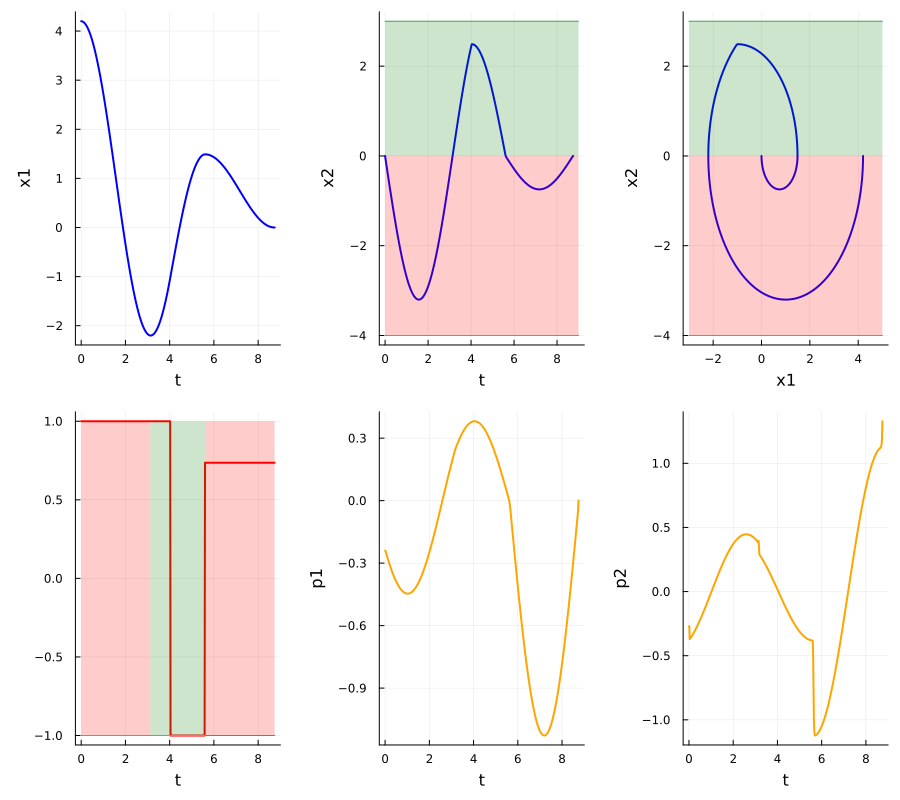

In [40]:
# Plots
t  = sol.t
x1 = sol.x1
x2 = sol.x2
λ  = sol.λ
u  = sol.u
xu = sol.xu
xv = sol.xv
p1 = sol.p1
p2 = sol.p2

println("xu = ", xu[end])
println("xv = ", xv[end])

# Compute the differences between adjacent elements
d = diff(u)

# Find the indices where the differences are non-zero
switchings = findall(abs.(d) .> 0.6)

# Print the result
switching_times = t[switchings] ; 


T  = t[end];

tc1    = switching_times[1]
tstar  = switching_times[2] 
tc2    = switching_times[3] ;

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory ", legend = false,linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  label=L"optimal trajectory ", legend = false,linecolor=:blue, linewidth=2)
plot!(x2_plot, [0., 9.], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red)
plot!(x2_plot, [0., 9.], [3.0, 3.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)

u1 = copy(u) ;

u1[0.  .<= t .<= tc1] .= λ[5]
u1[tc2 .<= t .<=   T] .= λ[switchings[3]+2]


control_plot = plot(t, u1,  xlabel = "t", label = "u",legend = false, linecolor=:red , linewidth=2)
plot!(control_plot, [0.0, tc1], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :red)
plot!(control_plot, [tc2, T], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :red)
plot!(control_plot, [tc1, tc2], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :green)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory ", legend = false,linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [-3, 5], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [-3, 5], [3.0, 3.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)
λ_plot = plot(t, λ, xlabel = "x1", ylabel = "λ",  legend = false)
plot!(t, λ, xlabel = "x1", ylabel = "λ",  legend = false)

p1_plot   = plot(t, p1,  xlabel = "t", ylabel = "p1",  legend = false,  linecolor=:orange , linewidth=2)
p2_plot   = plot(t, p2,  xlabel = "t", ylabel = "p2",  legend = false,  linecolor=:orange , linewidth=2)

plot( x1_plot,x2_plot, x1x2_plot, control_plot , p1_plot,p2_plot, layout = (2,3), size=(900, 800), left_margin=5mm)

In [7]:
jumpp2 = p2[switchings[3]+2] - p2[switchings[3]-2]  

-0.38498496444565616

# Indirect method

In [8]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");

In [9]:
# Dynamics
function F0(x)
    return [ x[2], -x[1]]
end

function F1(x)
    return [ 0.0 ,   1.0]
end


H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

# Hamiltonians: 
H(x, p, u)  =  H0(x, p) + u*H1(x,p)                             # pseudo-Hamiltonian

up(x, p) =   1.0
um(x, p) = - 1.0

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))


# Hamiltonians: control loss region 2
H2(x, b, y, p)  = H0(x, p) + b*H1(x, p) - y*p[2]                # pseudo-Hamiltonian
Hcl(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])                # control loss 2



# Flows
fp    = Flow(Hp)
fm    = Flow(Hm)
fcl   = Flow(Hcl) ;

In [10]:
t0 = 0.0
x0 = [4.2; 0.0]

# Shooting function
function SHOOT(p0, tt1, tt2, tt3, b1, jump2, TT) 
    
    pb0    = 0.0 
    py0    = 0.0
        
    x1, p1 = fp(t0 , x0, p0, tt1) 
    
    x2, p2 = fp(tt1, x1, p1, tt2)
    
    x3, p3 = fm(tt2, x2, p2, tt3)
    
    X4, P4 = fcl(tt3, [x3 ; b1 ; 0.0], [p3 - [0. , jump2]; pb0 ; py0], TT)

         s = zeros(eltype(p0), 8)
    
    s[1:2] = X4[1:2] - [ 0.0 , 0.0 ]                     # target
    s[3]   = x1[2] - 0.0                                 # first crossing 
    s[4]   = H1(x2, p2)                                  # switching
    s[5]   = x3[2] - 0.0                                 # second crossing 
    s[6]   = jump2 - p3[2]*(b1 + 1.)/(b1 - x3[1])        # jump
    s[7]   = Hp(x0, p0) - 1.0                            # free final time
    s[8]   = P4[3]                                       # averaged gradient condition 

    return s

end;

In [11]:
S(ξ) = SHOOT(ξ[1:2], ξ[3], ξ[4], ξ[5],ξ[6],ξ[7],ξ[8]);

In [12]:
ξ_guess = [p1[1] , p2[1], tc1, tstar, tc2,λ[div(switchings[3]+length(t),2)], jumpp2, t[end]]; # initial guess

In [13]:
S(ξ_guess)

8-element Vector{Float64}:
  0.020380968662301123
 -0.022202208415563605
 -0.03419835825999407
 -0.013743101339497342
  0.027131169611061507
 -1.2564608423244819
 -0.1345975885851971
 -0.029789512422296768

In [14]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0  = indirect_sol.zero[1:2]
    tt1  = indirect_sol.zero[3]
    tt2  = indirect_sol.zero[4]
    tt3  = indirect_sol.zero[5]
    b11  = indirect_sol.zero[6]
    jmp2 = indirect_sol.zero[7]
    T1   = indirect_sol.zero[8]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.256461e+00              NaN
     1     8.814424e-03     1.304966e+00
     2     2.384539e-04     2.506522e-02
     3     5.731494e-08     2.991415e-04
     4     1.031675e-14     4.768614e-08
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-0.24075806534764554, -0.2704382535671259, 3.1309054631932733, 4.022951153823759, 5.597149431406969, 0.744893673008441, -0.38498496444565616, 8.74554598657339]
 * Zero: [-0.25020024032048727, -0.3125, 3.1415926535897873, 4.0372574474475735, 5.608053774242464, 0.7489995996793956, 0.9347938137160706, 8.749646427832255]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5


In [15]:
tt1 - tc1 

0.010687190396514001

In [16]:
tt2 - tstar

0.014306293623814526

In [17]:
tt3 - tc2

0.010904342835495129

In [18]:
jmp2 - jumpp2

1.3197787781617267

In [19]:
t[end] - T1

-0.004100441258865217

In [20]:
b11 - λ[switchings[3]+2]

0.013115810475850753

In [21]:
ode_sol = fp((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = up.(xx1, pp1);

ode_sol = fp((tt1, tt2), xx1[end], pp1[end], saveat=0.1) ;
ttt2    = ode_sol.t ;
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ] ;
pp2     = [ ode_sol[3:4, j] for j in 1:size(ttt2, 1) ] ;
uu2     = up.(xx2, pp2)  ;

ode_sol = fm((tt2, tt3), xx2[end], pp2[end], saveat=0.1) ;
ttt3    = ode_sol.t ;
xx3     = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ] ;
pp3     = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] ;
uu3     = um.(xx3, pp3)  ;

ode_sol = fcl((tt3, T1), [xx3[end] ; b11 ; 0.0], [pp3[end] - [0., jmp2]; 0. ; 0.], saveat=0.1)
ttt4    = ode_sol.t
xx4     = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ]
pp4     = [ ode_sol[5:6, j] for j in 1:size(ttt4, 1) ] 
uu4     = b11.*ones(length(ttt4)) ;


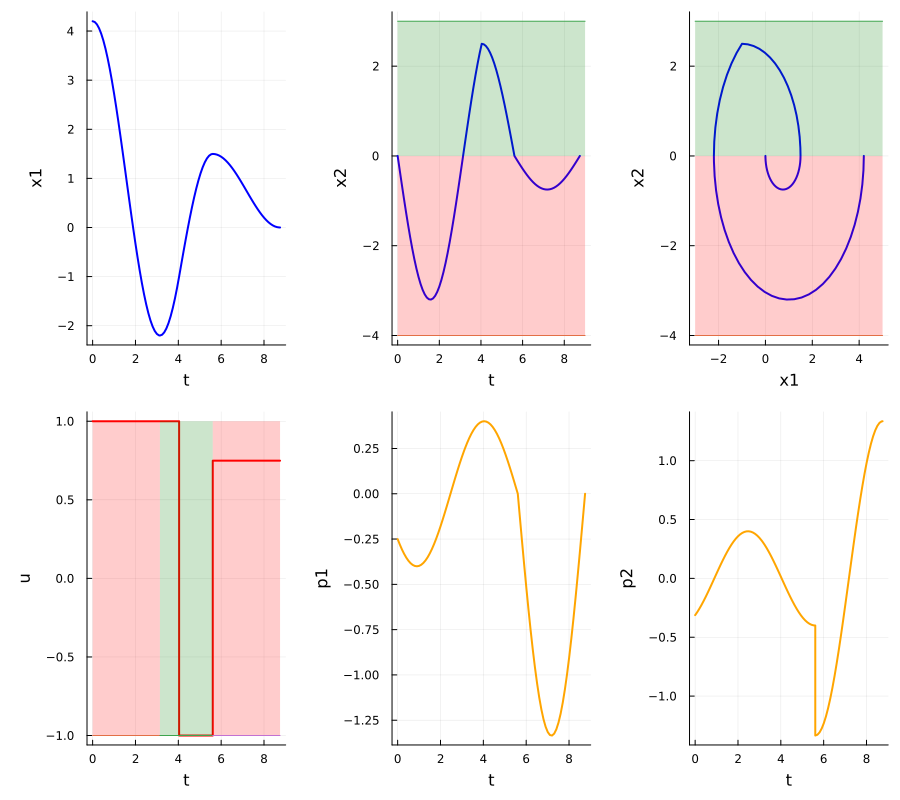

In [41]:
t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ]
x = [ xx1 ; xx2 ; xx3 ; xx4 ]
p = [ pp1 ; pp2 ; pp3 ; pp4  ]
u = [ uu1 ; uu2 ; uu3 ; uu4  ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false,  linecolor=:blue , linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false,  linecolor=:blue , linewidth=2)
plot!(x2_plot, [0., 9.], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red)
plot!(x2_plot, [0., 9.], [3.0, 3.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)

p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false, linecolor=:orange , linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false,  linecolor=:orange , linewidth=2)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false,  linecolor=:red , linewidth=2) #, linetype=:steppre)
plot!(u_plot, [0.0, tt1], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :red)
plot!(u_plot, [tt1, tt3], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :green)
plot!(u_plot, [tt3, T1], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :red)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false,  linecolor=:blue , linewidth=2)
plot!(x1x2_plot, [-3, 5], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [-3, 5], [3.0, 3.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)

plot( x1_plot,x2_plot, x1x2_plot, u_plot , p1_plot,p2_plot, layout = (2,3), size=(900, 800), left_margin=5mm)